
<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/04/cropped-Logo_Quantreo_transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Hyper Paramaters optimization
The objective is to allow you to find the optimal parameters of our strategy.

<br> 
### Content 
* Heatmap parameter selection
* Statistics parameter selection
* Create a function

### Environnement

In [ ]:
!pip install ta
!pip install yfinance

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=3d781d3a9ea45f006fa107f71d492c8bb4091a499b8888031d81fa8bc8907b03
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 6.3 MB 9.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=c19b42396dbb1e090bc7616e507da642985be60a8588d3e1c02bd1238c691969
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import ta
import yfinance as yf

import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Functions

In [ ]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")
  
  val["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=window).rsi()


  
  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = f["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [ ]:
def drawdown_function(serie):
  
  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
def BackTest(serie):

  # Import the benchmarcl
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  sp500.columns = ["SP500"]

  val = pd.concat((serie, sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Put the cumsum
  cum.plot(serie.cumsum(), color="#39B3C7")
  cum.plot(val["Adj Close"].cumsum(), color="#B85A0F")
  cum.legend(["Portfolio", "SP500"])
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()

  # Compute the sortino
  sortino = np.sqrt(252)*serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val,rowvar=False)[0][1] /np.var(val["Adj Close"].dropna())

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")


# Section 1: Heatmap parameter selection

[*********************100%***********************]  1 of 1 completed


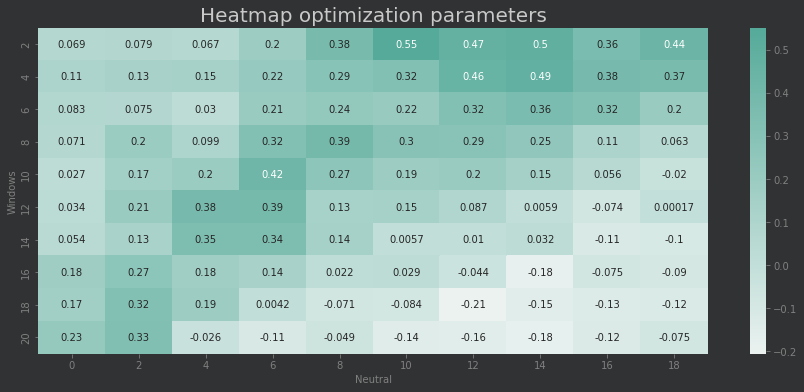

In [ ]:
# Import the data
f = yf.download("GOOG")

# We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]


# We set matrix with only zeros 
grid = np.zeros([len(neutral_values), len(window_values)])

# We will in parmters calculate the return of the strategy for each combinaison
for i in range(len(neutral_values)):
  for j in range(len(window_values)):

    # Compute return strategy
    return_rsi = RSI(f, neutral_values[i], window_values[j])

    # Compute annualized sortino
    grid[i][j] = np.sqrt(252) * return_rsi.mean() / (return_rsi[return_rsi<0].std()+0.00001)

# Adapt the size
plt.figure(figsize=(15,6))

# Palette for color
pal = sns.color_palette("light:#5A9", as_cmap=True)

# Plot the heatmap
sns.heatmap(grid, annot=True, xticklabels=neutral_values, yticklabels=window_values, cmap = pal)

# Put a title
plt.title("Heatmap optimization parameters", size=20)

# Put a xlabel
plt.xlabel("Neutral")

# Put a xlabel
plt.ylabel("Windows")

# Show the graph
plt.show()

In [ ]:
# We create just a function for the previous code
def grid_parameters(f):

  # We set lists for the possible values of neutral and window
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # We set matrix with only zeros 
  grid = np.zeros([len(neutral_values), len(window_values)])

  # We wil calculate the return of the strategy for each combinaison
  for i in range(len(neutral_values)):
    for j in range(len(window_values)):

      # Compute return strategy
      return_rsi = RSI(f, neutral_values[i], window_values[j])

      # Compute annualized sortino
      grid[i][j] = np.sqrt(252) * return_rsi.mean() / return_rsi[return_rsi<0].std()

  return grid

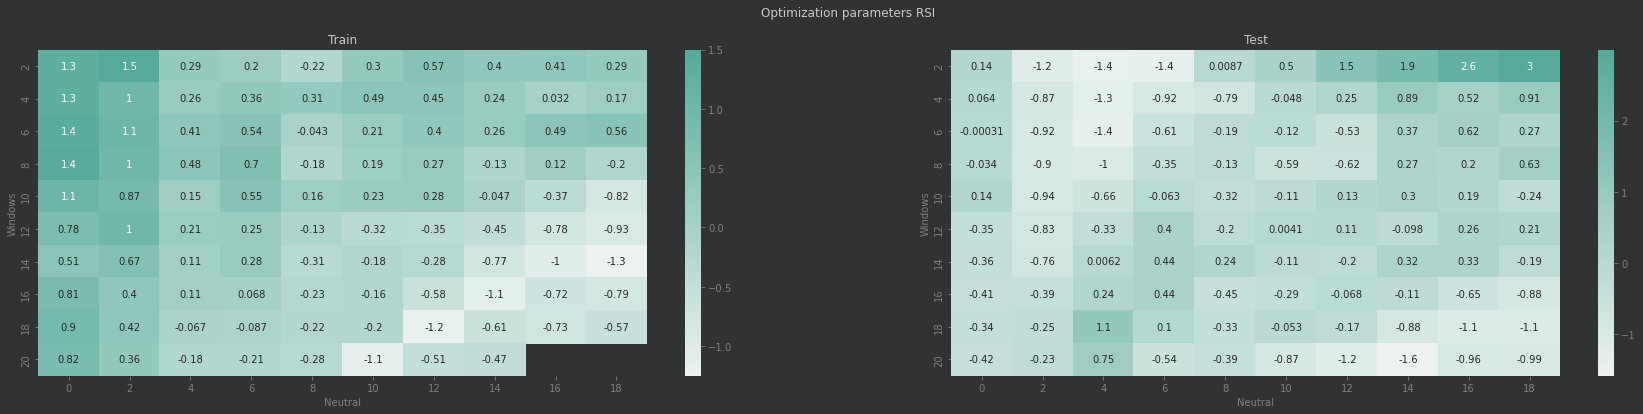

In [ ]:
# We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Set some datasets
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Create the grids
grid_train = grid_parameters(f.loc[start_train:end_train])
grid_test = grid_parameters(f.loc[start_test:end_test])

# Create a subplots
fig, (train,test) = plt.subplots(1,2,figsize=(30,6))

# Put a sup title
fig.suptitle("Optimization parameters RSI")

# Change the color
pal = sns.color_palette("light:#5A9", as_cmap=True)

# Train
# Put train heatmap
sns.heatmap(grid_train, annot=True, ax=train, xticklabels=neutral_values, yticklabels=window_values, cmap = pal)

# Set a title
train.set_title("Train")

# Set a xlabel
train.set_xlabel("Neutral")

# Set a ylabel
train.set_ylabel("Windows")


# Test
# Put test heatmap
sns.heatmap(grid_test, annot=True, ax=test, xticklabels=neutral_values, yticklabels=window_values, cmap= pal)

# Set a title
test.set_title("Test")

# Set a xlabel
test.set_xlabel("Neutral")

# Set a ylabel
test.set_ylabel("Windows")   


# Show the graph
plt.show()

[*********************100%***********************]  1 of 1 completed


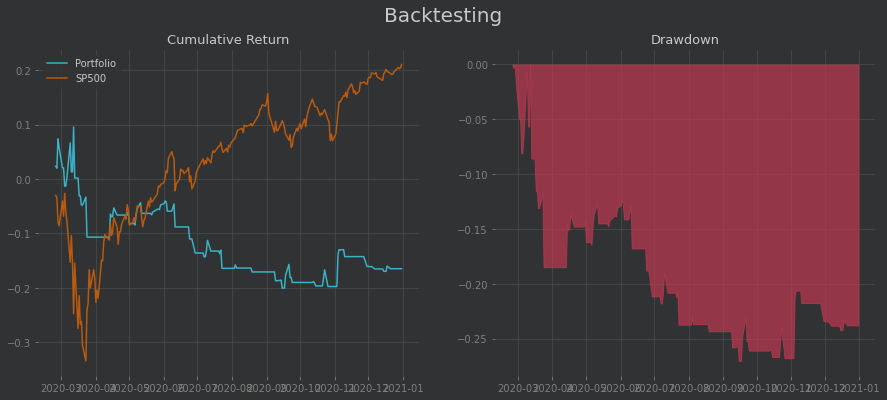

Sortino: -0.609
Beta: -0.273
Alpha: -0.244
MaxDrawdown: 27.041 %


In [ ]:
# BackTest
BackTest(RSI(f.loc[start_valid:end_valid],16,6))

# Section 2: Statistics parameter selection

In [ ]:
# statistical slection parameters

# We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Set some Border of the datasets
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Initialize the list
resume = []

# Loop to add the values in the list
for i in range(len(neutral_values)):
    for j in range(len(window_values)):

      # Compute the returns
      return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
      return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

      # Compute the Sortino
      sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
      sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

      # We do list of list to do a dataframe
      values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
      resume.append(values)

resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino test"])

In [ ]:
# Order by Sortino
ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)


best = ordered_resume.iloc[0:1,:]

# Compute the sortino
Strain = best["Sortino Train"].values[0]
Stest = best["Sortino test"].values[0]
# Initialize the i
i = 0

for i in range(len(resume)):
    # Take the best
    best = ordered_resume.iloc[0+i:1+i,:]

    # Compute the sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino test"].values[0]

    # Take best neutral and best window
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    if Stest>0.5 and Strain>0.5:
      break

    # If there is no optimal parameters  
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0



In [ ]:
# Plot the values
best_neutral, best_window, Strain, Stest

(0, 14, 0.5653562278760981, 1.5023398956221412)

[*********************100%***********************]  1 of 1 completed


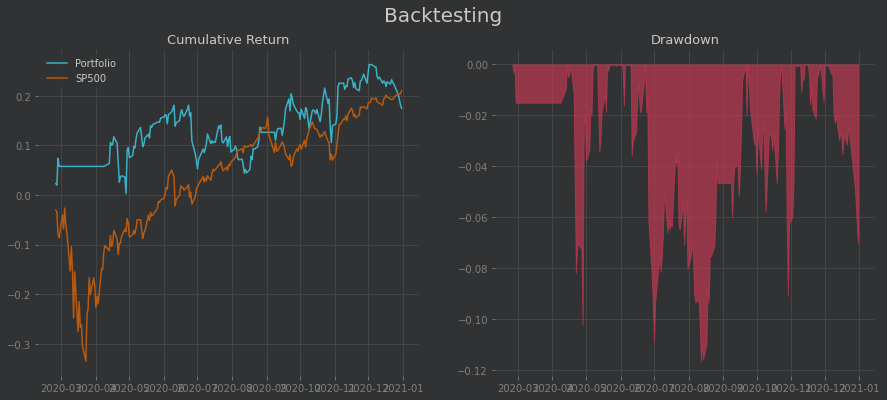

Sortino: 1.06
Beta: 0.115
Alpha: 0.179
MaxDrawdown: 11.638 %


In [ ]:
# BackTest
BackTest(RSI(f.loc[start_valid:end_valid],0,14))

# Section 3: Create a function to use it in the next sections

In [ ]:
def opt(f):
  # We set lists for the possible values of neutral and window
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # Set some Border of the datasets
  start_train, end_train = "2017-01-01", "2019-01-01"
  start_test, end_test = "2019-01-01", "2020-01-01"
  start_valid, end_valid = "2020-01-01", "2021-01-01"


  # Initialize the list
  resume = []

  # Loop to add the values in the list
  for i in range(len(neutral_values)):
      for j in range(len(window_values)):
        # Compute the returns
        return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
        return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

        # Compute the sortino
        sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
        sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

        # We do list of list to do a dataframe
        values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
        resume.append(values)

  resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino test"])

  # Order by sortino
  ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)



  for i in range(len(resume)):
    # Take the best
    best = ordered_resume.iloc[0+i:1+i,:]

    # Compute the sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino test"].values[0]

    # Take best neutral and best window
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    # If the Sortino of the train and the test are good we stop the loop
    if Stest>0.5 and Strain>0.5:
      break

    # If there is no values enought good the put 0 in all values
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0
  return [best_neutral, best_window, Strain, Stest]

In [ ]:
# Find optimal parameters
m = yf.download("GOOG")
opt(m.dropna())

[*********************100%***********************]  1 of 1 completed


[0, 14, 0.5653562278760981, 1.5023398956221412]

[*********************100%***********************]  1 of 1 completed


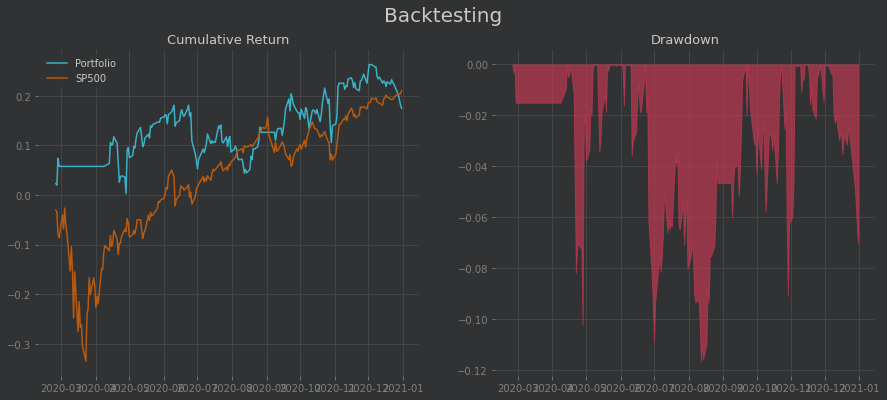

Sortino: 1.06
Beta: 0.115
Alpha: 0.179
MaxDrawdown: 11.638 %


In [ ]:
# BackTest
BackTest(RSI(m.loc[start_valid:end_valid], 0, 14))